In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'comp451/Project/visual-transformer'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
import os
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

os.chdir('/content/drive/MyDrive/comp451/Project/visual-transformer')


Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import models
from models.vt_resnet import VTResNet
from models.resnet import BasicBlock
import matplotlib.pyplot as plt
import random
import pickle
import numpy as np

In [4]:
def store_params(content, name):
    f = open("logs/" + name + ".pkl","wb")
    pickle.dump(content, f)
    f.close()

def load_params(name):
    fl = open("logs/" + name + ".pkl", "rb")
    loaded = pickle.load(fl)
    return loaded


In [5]:
def random_seed():
    np.random.seed(8)
    torch.manual_seed(8)
    random.seed(8)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [8]:
data_train = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=transform)
data_valid = torchvision.datasets.CIFAR10('/data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def train(model, optimizer, data_loader):
   
    total_samples = len(data_loader.dataset)
    
    model.train()
    model.to(device)

    loss_history = []
    for i, (data, target) in enumerate(data_loader):
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
    return loss_history

In [10]:
def evaluate(model, data_loader, mode):
    
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    loss_history = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage '+ mode + ' loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
    accuracy = 100.0 * correct_samples / total_samples
    return accuracy, loss_history

In [11]:
def train_attempt(model, optimizer, train_data, valid_data, epochs, lr, 
                  lr_decay, decay_every, weight_decay, optim):

    all_history = []
    final_train_acc = 0
    final_valid_acc = 0
    for i in range(epochs):

        if i % decay_every == 0:
            lr *= lr_decay
            optimizer = optim(model.parameters(), lr=lr, weight_decay=weight_decay)

        history = train(model, optimizer, train_data)
        all_history = all_history + history
        plt.plot(history)
        plt.show()
        print("Epoch " + str(i) + " done.")
        final_valid_acc, valid_hist = evaluate(model, valid_data, 'test')
        final_train_acc, train_hist = evaluate(model, train_data, 'train')
        
    plt.plot(all_history)
    plt.show()

    return final_valid_acc, final_train_acc, all_history

In [12]:
def param_search():

    valid_loader = DataLoader(Subset(data_valid, list(range(5000))), batch_size=128, shuffle=False)

    l = 0.005
    r = 0.004
    lr_trials = 1
    lrs = [0.0002, 0.0008, 0.0006, 0.0004]
    Ls = [8]
    Ns = [128]
    Ds = [1024]
    optims = [torch.optim.Adam]
    weight_decay = 4e-5
    lr_decay = 1
    decay_every = 50
    epochs = 10
    enc_layers = [2, 3]
    n_heads = [8]
    fc_dims = [1024, 512, 2048]
    t_dropout = [0.5]
    layer_planes = [[64, 128, 256, 512]] # [16, 32, 64, 128]

    best = {}
    best['valid_acc'] = 0

    all_count = 0
    best_count = 0


    for N in Ns:
        for D in Ds:
            for L in Ls:
                for enc_layer in enc_layers:
                    for n_head in n_heads:
                        for fc_dim in fc_dims:
                            for dropout in t_dropout:
                                for layer_plane in layer_planes:
                                    for optim in optims:
                                        #for _ in range(lr_trials):
                                        for lr in lrs:   
                                            # lr = random.uniform(l, r)
                                            # lr = 0.00425809562274105

                                            train_loader = DataLoader(data_train, batch_size=N, shuffle=True)

                                            model = VTResNet(
                                                resnet_block=BasicBlock,
                                                layers=[2,2,2,1],
                                                tokens=L,
                                                token_channels=D,
                                                input_dim=32,
                                                layer_planes=layer_plane,
                                                transformer_enc_layers=enc_layer,
                                                transformer_heads=n_head,
                                                transformer_fc_dim=fc_dim,
                                                transformer_dropout=dropout,
                                                num_classes=10
                                            )
                                            
                                        
                                            optimizer = optim(model.parameters(), lr=lr, weight_decay=weight_decay)

                                            valid_acc, train_acc, all_hist = train_attempt(
                                                model, 
                                                optimizer, 
                                                train_loader, 
                                                valid_loader, 
                                                epochs,
                                                lr,
                                                lr_decay,
                                                decay_every,
                                                weight_decay,
                                                optim
                                                )

                                            if valid_acc > best['valid_acc']:
                                                best['valid_acc'] = valid_acc
                                                best['train_acc'] = train_acc
                                                best['lr'] = lr
                                                best['L'] = L
                                                best['N'] = N
                                                best['D'] = D
                                                best['optim'] = optim
                                                best['enc_layer'] = enc_layer
                                                best['fc_dim'] = fc_dim
                                                best['layer_plane'] = layer_plane
                                                best['dropout'] = dropout
                                                best['n_head'] = n_head

                                                store_params(best, "best_params_7_" + str(best_count))
                                                best_count += 1


                                            store_params(best, "params_7_" + str(all_count))
                                            all_count += 1

                                            print('Best So Far:')
                                            print(best)

    return best

[    0/50000 (  0%)]  Loss: 2.5346
[12800/50000 ( 26%)]  Loss: 1.6637
[25600/50000 ( 51%)]  Loss: 1.5557
[38400/50000 ( 77%)]  Loss: 1.1890


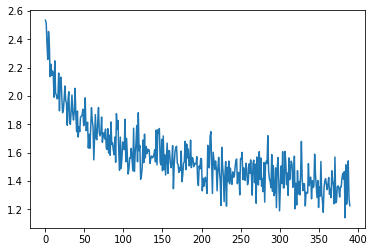

Epoch 0 done.

Average test loss: 1.3078  Accuracy: 2691/ 5000 (53.82%)


Average train loss: 1.1986  Accuracy:28743/50000 (57.49%)

[    0/50000 (  0%)]  Loss: 1.1154
[12800/50000 ( 26%)]  Loss: 1.2466
[25600/50000 ( 51%)]  Loss: 1.2067
[38400/50000 ( 77%)]  Loss: 1.1462


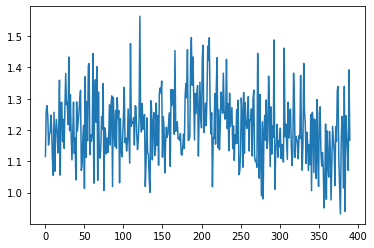

Epoch 1 done.

Average test loss: 1.1764  Accuracy: 2902/ 5000 (58.04%)



KeyboardInterrupt: ignored

In [13]:
random_seed()
best = param_search()
print(best) 
store_params(best, "best_of_all_test")

In [ ]:
"""

Best So Far:

{
    'valid_acc': tensor(72.2200, device='cuda:0'), 
    'train_acc': tensor(77.9020, device='cuda:0'), 
    'lr': 0.01, 
    'L': 8, 
    'N': 128, 
    'D': 128, 
    'optim': <class 'torch.optim.adam.Adam'>
    'transformer_dim_feedforward': 2024,
    'transformer_nhead': tokens,
    'transformer_ecnoder_layers: 2
    'transformer_dropout': 0.5,
    'epochs':20
}

{
    'valid_acc': tensor(69.6200, device='cuda:0'), 
    'train_acc': tensor(77.0780, device='cuda:0'), 
    'lr': 0.00425809562274105, 
    'L': 8, 
    'N': 128, 
    'D': 512, 
    'optim': <class 'torch.optim.adam.Adam'>,
    'transformer_dim_feedforward': 2024,
    'transformer_nhead': tokens,
    'transformer_ecnoder_layers: 2
    'transformer_dropout': 0.5,
    'epochs':15
}


{
    'valid_acc': tensor(67.8200, device='cuda:0'), 
    'train_acc': tensor(74.8360, device='cuda:0'), 
    'lr': 0.00425809562274105, 
    'L': 8, 
    'N': 128, 
    'D': 128, 
    'optim': <class 'torch.optim.adam.Adam'>,
    'transformer_dim_feedforward': 512,
    'transformer_nhead': L,
    'transformer_ecnoder_layers: 2
    'transformer_dropout': 0.5,
    'epochs':15
}

"""

In [ ]:
resnet = models.resnet18(pretrained=False)
# print(resnet)

[    0/50000 (  0%)]  Loss: 7.1023
[12800/50000 ( 26%)]  Loss: 1.2639
[25600/50000 ( 51%)]  Loss: 1.2159
[38400/50000 ( 77%)]  Loss: 1.1026


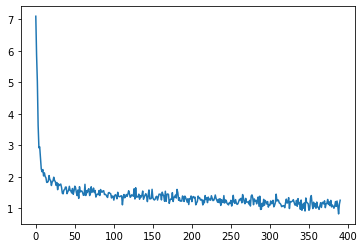

Epoch 0 done.

Average test loss: 1.3244  Accuracy: 5317/10000 (53.17%)


Average train loss: 1.2486  Accuracy:27639/50000 (55.28%)

[    0/50000 (  0%)]  Loss: 1.0698
[12800/50000 ( 26%)]  Loss: 1.1822
[25600/50000 ( 51%)]  Loss: 0.7798
[38400/50000 ( 77%)]  Loss: 0.8491


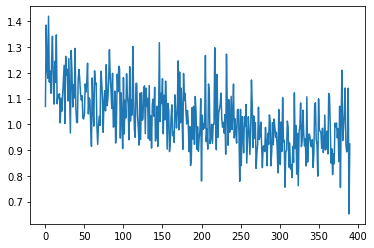

Epoch 1 done.

Average test loss: 1.0523  Accuracy: 6400/10000 (64.00%)


Average train loss: 0.9261  Accuracy:33712/50000 (67.42%)

[    0/50000 (  0%)]  Loss: 0.8272
[12800/50000 ( 26%)]  Loss: 0.8865
[25600/50000 ( 51%)]  Loss: 0.6663
[38400/50000 ( 77%)]  Loss: 0.8569


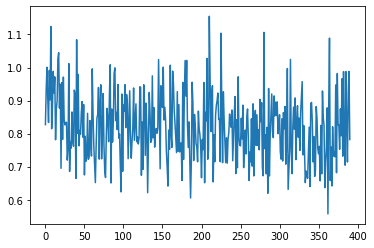

Epoch 2 done.

Average test loss: 0.8591  Accuracy: 7032/10000 (70.32%)


Average train loss: 0.6783  Accuracy:38151/50000 (76.30%)

[    0/50000 (  0%)]  Loss: 0.6673
[12800/50000 ( 26%)]  Loss: 0.7021
[25600/50000 ( 51%)]  Loss: 0.5850
[38400/50000 ( 77%)]  Loss: 0.6247


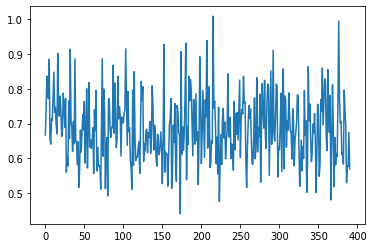

Epoch 3 done.

Average test loss: 0.7998  Accuracy: 7296/10000 (72.96%)


Average train loss: 0.5566  Accuracy:40350/50000 (80.70%)

[    0/50000 (  0%)]  Loss: 0.5161
[12800/50000 ( 26%)]  Loss: 0.5642
[25600/50000 ( 51%)]  Loss: 0.6787
[38400/50000 ( 77%)]  Loss: 0.5133


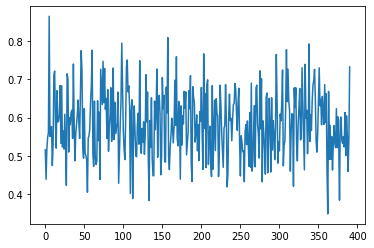

Epoch 4 done.

Average test loss: 0.7993  Accuracy: 7354/10000 (73.54%)


Average train loss: 0.4756  Accuracy:41631/50000 (83.26%)

[    0/50000 (  0%)]  Loss: 0.4973
[12800/50000 ( 26%)]  Loss: 0.4920
[25600/50000 ( 51%)]  Loss: 0.4481
[38400/50000 ( 77%)]  Loss: 0.5170


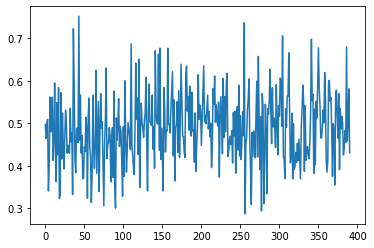

Epoch 5 done.

Average test loss: 0.7576  Accuracy: 7506/10000 (75.06%)


Average train loss: 0.3523  Accuracy:43911/50000 (87.82%)

[    0/50000 (  0%)]  Loss: 0.3622
[12800/50000 ( 26%)]  Loss: 0.5945
[25600/50000 ( 51%)]  Loss: 0.4519
[38400/50000 ( 77%)]  Loss: 0.3730


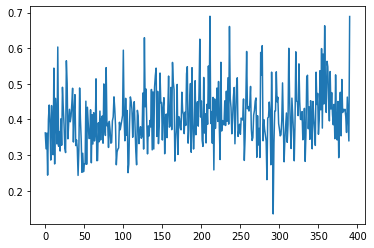

Epoch 6 done.

Average test loss: 0.7544  Accuracy: 7569/10000 (75.69%)


Average train loss: 0.2741  Accuracy:45390/50000 (90.78%)

[    0/50000 (  0%)]  Loss: 0.2582
[12800/50000 ( 26%)]  Loss: 0.2547
[25600/50000 ( 51%)]  Loss: 0.4104
[38400/50000 ( 77%)]  Loss: 0.4111


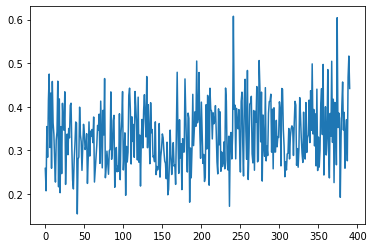

Epoch 7 done.

Average test loss: 0.8035  Accuracy: 7569/10000 (75.69%)


Average train loss: 0.2217  Accuracy:46299/50000 (92.60%)

[    0/50000 (  0%)]  Loss: 0.1347
[12800/50000 ( 26%)]  Loss: 0.2456
[25600/50000 ( 51%)]  Loss: 0.3999
[38400/50000 ( 77%)]  Loss: 0.3487


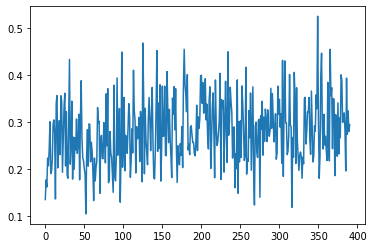

Epoch 8 done.

Average test loss: 0.9241  Accuracy: 7414/10000 (74.14%)


Average train loss: 0.2387  Accuracy:45826/50000 (91.65%)

[    0/50000 (  0%)]  Loss: 0.1707
[12800/50000 ( 26%)]  Loss: 0.2793
[25600/50000 ( 51%)]  Loss: 0.3885
[38400/50000 ( 77%)]  Loss: 0.2201


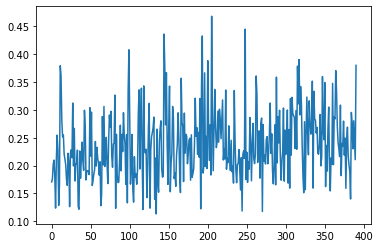

Epoch 9 done.

Average test loss: 0.9061  Accuracy: 7565/10000 (75.65%)


Average train loss: 0.1568  Accuracy:47308/50000 (94.62%)

[    0/50000 (  0%)]  Loss: 0.1704
[12800/50000 ( 26%)]  Loss: 0.0784
[25600/50000 ( 51%)]  Loss: 0.1650
[38400/50000 ( 77%)]  Loss: 0.2747


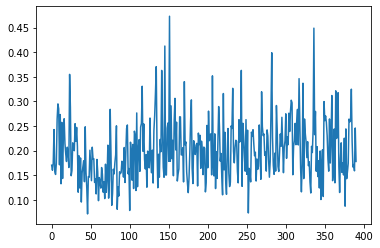

Epoch 10 done.

Average test loss: 1.0207  Accuracy: 7459/10000 (74.59%)


Average train loss: 0.1642  Accuracy:47150/50000 (94.30%)

[    0/50000 (  0%)]  Loss: 0.1788
[12800/50000 ( 26%)]  Loss: 0.1218
[25600/50000 ( 51%)]  Loss: 0.1047
[38400/50000 ( 77%)]  Loss: 0.2348


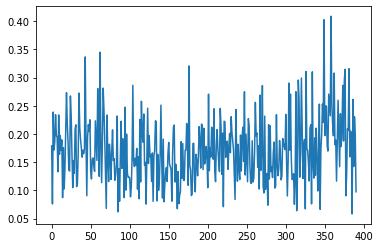

Epoch 11 done.

Average test loss: 1.0071  Accuracy: 7514/10000 (75.14%)


Average train loss: 0.1316  Accuracy:47683/50000 (95.37%)

[    0/50000 (  0%)]  Loss: 0.1549
[12800/50000 ( 26%)]  Loss: 0.2117
[25600/50000 ( 51%)]  Loss: 0.1566
[38400/50000 ( 77%)]  Loss: 0.1519


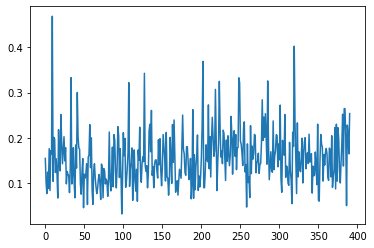

Epoch 12 done.

Average test loss: 1.0754  Accuracy: 7512/10000 (75.12%)


Average train loss: 0.1208  Accuracy:47954/50000 (95.91%)

[    0/50000 (  0%)]  Loss: 0.0332
[12800/50000 ( 26%)]  Loss: 0.1885
[25600/50000 ( 51%)]  Loss: 0.2250
[38400/50000 ( 77%)]  Loss: 0.0817


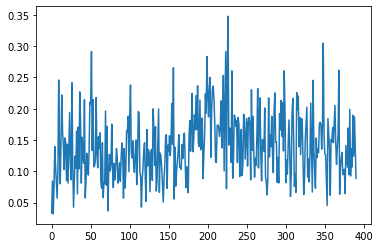

Epoch 13 done.

Average test loss: 1.0332  Accuracy: 7602/10000 (76.02%)


Average train loss: 0.0777  Accuracy:48680/50000 (97.36%)

[    0/50000 (  0%)]  Loss: 0.0529


KeyboardInterrupt: ignored

In [ ]:
epochs = 30
lr = 0.001
lr_decay = 1
decay_every = 30
weight_decay = 4e-5
optim = torch.optim.Adam
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr, weight_decay=weight_decay)


N = 128

train_loader = DataLoader(data_train, batch_size=N, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=N, shuffle=False)

valid_acc, train_acc, all_hist = train_attempt(
    resnet, 
    optimizer, 
    train_loader, 
    valid_loader, 
    epochs,
    lr,
    lr_decay,
    decay_every,
    weight_decay,
    optim
)

print(valid_acc, train_acc)